# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

warnings.filterwarnings("ignore")

2024-07-09 20:46:44.518452: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 20:46:44.720448: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 20:46:44.962723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 20:46:45.178049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 20:46:45.179502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 20:46:45.530843: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk"
}

# Load genotypes

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [4]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [5]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

In [6]:
complete['CG2_AF_0.4634'].unique()

array([ 0.,  1., -1.])

In [7]:
complete

snps,CG1_AF_0.49585,CG2_AF_0.4634,CG5_AF_0.375825,CG11_AF_0.474475,CG18_AF_0.49585,CG22_AF_0.232975,CG26_AF_0.46405,CG30_AF_0.233825,CG38_AF_0.4458,CG46_AF_0.498875,...,VRG984_AF_0.001875,VRG986_AF_0.032175,VRG987_AF_0.00185,VRG988_AF_0.006625,VRG989_AF_0.045625,VRG992_AF_0.0165,VRG995_AF_0.02635,VRG996_AF_0.023175,VRG998_AF_0.00645,VRG999_AF_0.0363
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Load populations

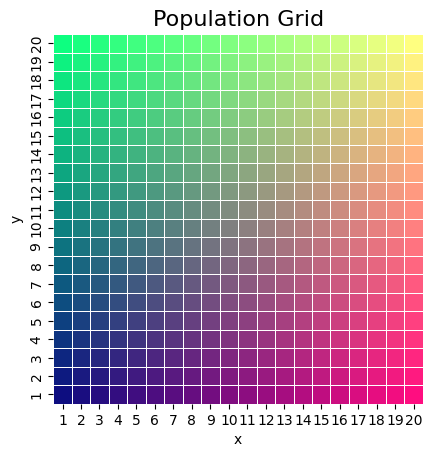

In [8]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()



# True maf per populations

In [9]:
true_population_maf_dfs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truemafperpop.pkl")

# Create snp effect

In [10]:
def multi(arr, effectsize):
    return [1 * (num + 0.001) * effectsize for num in arr]

def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in common.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in common.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_common = pd.DataFrame(data)
beta_common['maf'] = "common"

numbers_af = [float(col.split('_AF_')[1]) for col in rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_rare = pd.DataFrame(data)
beta_rare['maf'] = "rare"

numbers_af = [float(col.split('_AF_')[1]) for col in very_rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in very_rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_very_rare = pd.DataFrame(data)
beta_very_rare['maf'] = "very rare"

betas = pd.concat([beta_common, beta_rare, beta_very_rare], ignore_index=True)

In [11]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

In [12]:
pre_var = phenos_mono.copy()

In [13]:
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 0.001
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)

In [14]:
y = phenos_mono.copy()

# Analysis

In [46]:
# beta1 * X  = y (should be the best)
b1x__y = manhattan_linear(complete, y)

Snp specific phenotype!
No Covs!


In [47]:
# beta1 * X + betas * pop_coordinates = y
b1x_b2pop__y = manhattan_linear(complete, y, populations[['x','y']])

Snp specific phenotype!
Covs


In [48]:
q = true_population_maf_dfs.copy()
p = 1-q

In [49]:
# beta1 * (X - (p-q)) + betas * pop_coordinates = y
b1xcorr_b2pop__y = manhattan_linear(complete-(p-q), y, populations[['x','y']])

Snp specific phenotype!
Covs


In [50]:
# beta1 * (X - (p-q)) + betas * pop_coordinates = y
b1xcorr_b2pop__y = manhattan_linear(complete, y, populations[['x','y']])

Snp specific phenotype!
Covs


In [51]:
nr_common_PCs = 35
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
PC_common= PC_common[pc_columns]

In [60]:
# beta1 * X + betas * PCs = y
b1xcorr_b2pcs__y = manhattan_linear(complete, y, PC_common)

Snp specific phenotype!
Covs


In [53]:
"""
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
# Standardize the data
y_preds = []
y_names = []
scaler = StandardScaler()
PC_scaled = scaler.fit_transform(PC_common)
i = 0
for phenotype in list(y.columns):
    X_train, X_test, y_train, y_test = train_test_split(PC_scaled, y[[phenotype]], test_size=0.2, random_state=42)
    # Build the feed-forward neural network model
    model = Sequential()
    model.add(Dense(5, input_dim=nr_common_PCs, activation='elu'))
    model.add(Dense(1, activation='linear'))  # Assuming regression problem; use 'sigmoid' or 'softmax' for classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model with early stopping
    history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2, 
                        callbacks=[early_stopping], verbose=0)
    
    # Predicting using the model (optional)
    y_pred = model.predict(PC_scaled)
    y_preds.append(y_pred.flatten())
    y_names.append(phenotype)
    print(f"{np.round(i/len(list(y.columns)),2)}%")
    i+= 1

pheno_pred_df = pd.DataFrame(np.array(y_preds)).T
pheno_pred_df.columns = complete.columns
pheno_pred_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/predicted_pheno_PCA_{nr_common_PCs}_PCs.pkl")
"""

'\nfrom sklearn.model_selection import train_test_split\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\nfrom tensorflow.keras.callbacks import EarlyStopping\n# Standardize the data\ny_preds = []\ny_names = []\nscaler = StandardScaler()\nPC_scaled = scaler.fit_transform(PC_common)\ni = 0\nfor phenotype in list(y.columns):\n    X_train, X_test, y_train, y_test = train_test_split(PC_scaled, y[[phenotype]], test_size=0.2, random_state=42)\n    # Build the feed-forward neural network model\n    model = Sequential()\n    model.add(Dense(5, input_dim=nr_common_PCs, activation=\'elu\'))\n    model.add(Dense(1, activation=\'linear\'))  # Assuming regression problem; use \'sigmoid\' or \'softmax\' for classification\n    \n    # Compile the model\n    model.compile(optimizer=\'adam\', loss=\'mean_squared_error\', metrics=[\'mae\'])\n    \n    # Define early stopping callback\n    early_stopping = EarlyStopping(monitor=\'val_loss\', patience=5, restore_

In [54]:
pheno_pred_df = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/predicted_pheno_PCA_{nr_common_PCs}_PCs.pkl")

In [79]:
# beta1 * X + ypred = y
b1x_b2ypred__y = manhattan_linear((p-q), y-pheno_pred_df)

Snp specific phenotype!
No Covs!


In [80]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_no_cov"] = np.sort(b1x__y['-logPs'])
df_bests["-logP_true_pops_as_cov"] = np.sort(b1x_b2pop__y['-logPs'])
df_bests["-logP_true_pops_as_cov_X_corrected"] = np.sort(b1xcorr_b2pop__y['-logPs'])
df_bests["-logP_ypred_as_cov"] = np.sort(b1x_b2ypred__y['-logPs'])

df_bests["-logP_Pcs_as_cov"] = np.sort(b1xcorr_b2pcs__y['-logPs'])

# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

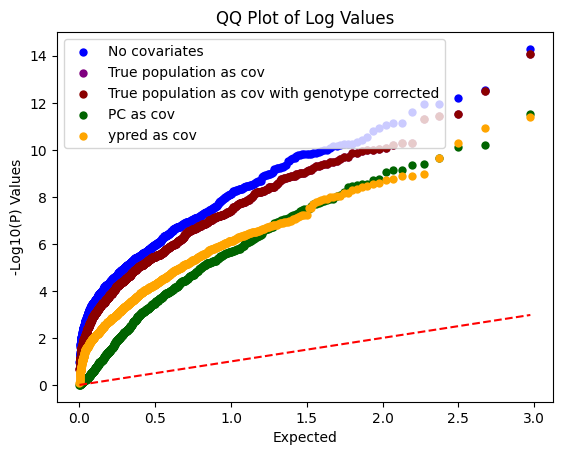

In [81]:
sns.scatterplot(x='expected_logP', y='-logP_no_cov', data=df_bests, color='blue', label='No covariates', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pops_as_cov', data=df_bests, color='purple', label='True population as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pops_as_cov_X_corrected', data=df_bests, color='darkred', label='True population as cov with genotype corrected', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_Pcs_as_cov', data=df_bests, color='darkgreen', label='PC as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_ypred_as_cov', data=df_bests, color='orange', label='ypred as cov', linewidth=0)


# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()